# Post workshop 6B walkthrough: Evolving an AI to play Pong

In [1]:
from turtle import Turtle, Screen, Shape
import random
import math
from datetime import datetime
import numpy as np

In [2]:
class UndrawnTurtle(): # We use this to keep track of the turtles without having to draw them
    def __init__(self):
        self.x, self.y, self.x_prev, self.y_prev, self.angle = 0.0, 0.0, 0.0, 0.0, 0.0

    def position(self):
        return self.x, self.y

    def xcor(self):
        return self.x

    def ycor(self):
        return self.y

    def xcor_prev(self):
        return self.x_prev

    def ycor_prev(self):
        self.y_prev = self.y
        return self.y_prev
    
    def setx(self, xcor):
        self.x_prev = self.x
        self.x = xcor

    def sety(self, ycor):
        self.y = ycor
    
    def forward(self, distance):
        angle_radians = math.radians(self.angle)
        self.x_prev = self.x
        self.y_prev = self.y
        self.x += math.cos(angle_radians) * distance
        self.y += math.sin(angle_radians) * distance

    def backward(self, distance):
        self.forward(-distance)

    def right(self, angle):
        self.angle -= angle

    def left(self, angle):
        self.angle += angle

    def setpos(self, x, y = None):
        # Can be passed either a tuple or two numbers
        self.x_prev = self.x
        self.y_prev = self.y
        if y == None:
            self.x = x[0]
            self.y = y[1]
        else:
            self.x = x
            self.y = y

# This is the class containing all the game code

In [3]:
class DisplayGame:
        
    def __init__(self, window_height, window_width, bat_w_half, bat_h_half):
        # SCREEN
        self.screen = Screen()
        self.screen.setup(window_height, window_width)   # width, height
        self.screen.tracer(0)         # We will handle displaying of frames ourselves

        # PLAY ARENA
        self.play_top    = window_height / 2 - 80    # top of screen minus 100 units
        self.play_bottom = -window_height / 2 + 80   # 100 from bottom
        self.play_left   = -window_width / 2 + 50    # 50 from left
        self.play_right  = window_width / 2 - 50     # 50 from right

        self.area = Turtle()
        self.area.hideturtle()

        # batS
        self.L = Turtle()
        self.R = Turtle()
        self.L.penup()
        self.R.penup()

        # bats shape
        self.bat_shape = Shape("compound")
        self.bat_points = ((-bat_h_half, -bat_w_half),
                         (-bat_h_half, bat_w_half),
                         (bat_h_half, bat_w_half),
                         (bat_h_half, -bat_w_half))
        self.bat_shape.addcomponent(self.bat_points, "blue")
        self.screen.register_shape("bat", self.bat_shape)
        self.L.shape("bat")
        self.R.shape("bat")

        # SCORE
        self.score_turtle = Turtle()
        self.score_turtle.penup()
        self.score_turtle.hideturtle()

        # BALL
        self.ball = Turtle()
        self.ball.penup()
        self.ball.shape("circle")        # Use the built-in shape "circle"
        self.ball.color("blue")
        self.ball.shapesize( 0.5, 0.5)   # Stretch it to half default size

        self.reset()

    def reset(self):
        
        self.area.penup()
        self.area.goto(self.play_right, self.play_top)
        self.area.pendown()
        self.area.goto(self.play_left, self.play_top)
        self.area.goto(self.play_left, self.play_bottom)
        self.area.goto(self.play_right, self.play_bottom)
        self.area.goto(self.play_right, self.play_top)
        
         # Move bats into position
        self.L.setx(self.play_left + 10)
        self.R.setx(self.play_right - 10)
        
        self.update_score(0,0)
        self.screen.update()
        
    def update_ball_position(self, ball_x_pos, ball_y_pos):
        self.ball.setpos(ball_x_pos, ball_y_pos)
        
    def update_L_bat_position(self, L_x_pos, L_y_pos):
        self.L.setpos(L_x_pos, L_y_pos)

    def update_R_bat_position(self, R_x_pos, R_y_pos):
        self.R.setpos(R_x_pos, R_y_pos)

    def update_score(self, L_score, R_score):
        self.score_turtle.clear()
        self.score_turtle.goto(-self.screen.window_width()/4, self.screen.window_height()/2 - 40)
        self.score_turtle.write(L_score, align="center", font=("Arial", 32, "bold"))
        self.score_turtle.goto(self.screen.window_width()/4, self.screen.window_height()/2 - 40)
        self.score_turtle.write(R_score, align="center", font=("Arial", 32, "bold"))

In [4]:
class Pong:
        
    def __init__(self):

        self.window_height = 600
        self.window_width = 550
        
        # PLAY ARENA
        self.play_top    = self.window_height / 2 - 80    # top of screen minus 100 units
        self.play_bottom = -self.window_height / 2 + 80   # 100 from bottom
        self.play_left   = -self.window_width / 2 + 50    # 50 from left
        self.play_right  = self.window_width / 2 - 50     # 50 from right

        self.area = UndrawnTurtle()

        # batS
        self.L = UndrawnTurtle()
        self.R = UndrawnTurtle()

        # bat size
        self.bat_w_half = 5  
        self.bat_h_half = 35

        # BALL
        self.ball = UndrawnTurtle()
        self.ball_radius = 10 * 0.5

        self.ball_move_horiz = 0          # current x speed    
        self.ball_move_vert  = 0          # current y speed
        self.slow_ball_speed = 3
        self.fast_ball_speed = self.slow_ball_speed * 2

        self.ball_speed = self.slow_ball_speed
        self.maxBounceAngleRadians = 1.04 # ~60 degrees

        self.reset()

    def reset(self):
              
         # Move bats into position
        self.L.setx(self.play_left + 10)
        self.R.setx(self.play_right - 10)

        self.bat_L_move_direction = 0   # L bat movement direction in next frame
        self.bat_R_move_direction = 0   # R bat movement direction in next frame
        
        self.bat_move_vert = 5
        
        self.score_L = 0
        self.score_R = 0
        
        if random.random() > 0.5:
            self.direction_horiz = 1
        else:
            self.direction_horiz = -1
            
        self.start_ball_direction = self.direction_horiz
       
        self.reset_ball()
        
    def bat_is_allowed_to_move_here(self, new_y_pos):
        if (self.play_bottom > new_y_pos - self.bat_h_half) : 
            return False
        if (new_y_pos + self.bat_h_half > self.play_top) :   
            return False
        return True

    def update_bat_positions(self):
        L_new_y_pos = self.L.ycor() + (self.bat_L_move_direction * self.bat_move_vert)
        R_new_y_pos = self.R.ycor() + (self.bat_R_move_direction * self.bat_move_vert)
        if self.bat_is_allowed_to_move_here(L_new_y_pos):
            self.L.sety( L_new_y_pos )
        if self.bat_is_allowed_to_move_here(R_new_y_pos):
            self.R.sety( R_new_y_pos )

    def L_up(self):
        self.bat_L_move_direction = 1

    def L_down(self):
        self.bat_L_move_direction = -1

    def L_off(self):
        self.bat_L_move_direction = 0

    def R_up(self):
        self.bat_R_move_direction = 1

    def R_down(self):
        self.bat_R_move_direction = -1

    def R_off(self):
        self.bat_R_move_direction = 0

    def check_if_someone_scores(self):
        if (self.ball.xcor() + self.ball_radius) >= self.play_right:
            self.score_L += 1
            self.reset_ball()
            return True
        elif self.play_left >= (self.ball.xcor() - self.ball_radius):  
            self.score_R += 1
            self.reset_ball()
            return True
        else:
            return False

    def ball_collides_with_bat(self, bat):
        self.ball_speed = self.fast_ball_speed              # Set it to full speed after the first hit
        x_distance = abs(bat.xcor() - self.ball.xcor())
        y_distance = abs(bat.ycor() - self.ball.ycor())
        overlap_horizontally = (self.ball_radius + self.bat_w_half >= x_distance) 
        overlap_vertically   = (self.ball_radius + self.bat_h_half >= y_distance) 
        return overlap_horizontally and overlap_vertically         
  
    def update_ball_position(self):
        if (self.ball.ycor() + self.ball_radius > self.play_top) and (self.ball_move_vert > 0): 
            self.ball_move_vert *= -1
        elif (self.play_bottom > self.ball.ycor() - self.ball_radius) and (self.ball_move_vert < 0):  
            self.ball_move_vert *= -1
            
        if self.ball_collides_with_bat(self.L) and self.ball_move_horiz < 0:
            relativeIntersectY = self.ball.ycor() - self.L.ycor()
            normalizedRelativeIntersectionY = (relativeIntersectY / self.bat_h_half)
            bounceAngle = normalizedRelativeIntersectionY * self.maxBounceAngleRadians
            self.ball_move_vert = self.ball_speed * math.sin(bounceAngle)
            self.ball_move_horiz = self.ball_speed * math.cos(bounceAngle)
        elif self.ball_collides_with_bat(self.R) and self.ball_move_horiz > 0:
            relativeIntersectY = self.ball.ycor() - self.R.ycor()
            normalizedRelativeIntersectionY = (relativeIntersectY / self.bat_h_half)
            bounceAngle = normalizedRelativeIntersectionY * self.maxBounceAngleRadians
            self.ball_move_vert = self.ball_speed * math.sin(bounceAngle)
            self.ball_move_horiz = self.ball_speed * -math.cos(bounceAngle)

        self.ball.setx(self.ball.xcor() + self.ball_move_horiz)
        self.ball.sety(self.ball.ycor() + self.ball_move_vert)

    def reset_ball(self):     
        self.ball_speed = self.slow_ball_speed
        
        if self.start_ball_direction == 1:
            self.direction_horiz = -1
            self.start_ball_direction = -1
            self.ball.setpos((self.window_width / 2) - 100, (self.window_height / 2) - 50)
        else:
            self.direction_horiz = 1
            self.start_ball_direction = 1
            self.ball.setpos((-self.window_width / 2) + 100, (self.window_height / 2) - 50)          

        bounceAngle = random.uniform(0.2, self.maxBounceAngleRadians)
        
        self.ball_move_vert = self.ball_speed * math.sin(bounceAngle)
        self.ball_move_horiz = self.ball_speed * (self.direction_horiz*math.cos(bounceAngle))
        
    def L_move_AI(self): # Simple AI for moving the left bat
        if self.ball.xcor() < 60:
            if self.L.ycor() < (self.ball.ycor() -40 ):
                self.bat_L_move_direction = 1
            elif self.L.ycor() > (self.ball.ycor() + 40 ):
                self.bat_L_move_direction = -1
            else:
                self.bat_L_move_direction = 0
                
    def R_move_AI_hand_coded(self): # Simple AI for moving the right bat
        if self.ball.xcor() > -60:
            if self.R.ycor() < (self.ball.ycor() -35 ):
                self.bat_R_move_direction = 1
            elif self.R.ycor() > (self.ball.ycor() + 35 ):
                self.bat_R_move_direction = -1
            else:
                self.bat_R_move_direction = 0  

    def R_move_AI(self, AIbrain):
        output = AIbrain.feedForward( [self.ball.ycor(), self.ball.xcor(), self.ball.ycor_prev(), self.ball.xcor_prev(), self.R.ycor() ] )
        decision = np.argmax(output, axis=0)
        if decision == 1:
            self.bat_R_move_direction = 1
        elif decision == 2:
            self.bat_R_move_direction = -1

In [7]:
def playGame(AIbrain, headless=False, maxTimesteps=1000): # Pass your evolved AI in to here

    pongGame.reset()
    running = True
    timesteps = 0
    if not headless:
        pongDisplay = DisplayGame(pongGame.window_height, pongGame.window_width, pongGame.bat_w_half, pongGame.bat_h_half)
        
    for timesteps in range( maxTimesteps ):
        pongGame.L_move_AI()
        pongGame.R_move_AI(AIbrain)
        pongGame.update_bat_positions()
        pongGame.update_ball_position()          
        score_changed = pongGame.check_if_someone_scores()

        # Let your algorithm decide on its move here (the options are L.up, L.down, or L.off)
        if not headless:
            pongDisplay.update_ball_position( pongGame.ball.xcor(), pongGame.ball.ycor() )
            pongDisplay.update_L_bat_position( pongGame.L.xcor(), pongGame.L.ycor() )
            pongDisplay.update_R_bat_position( pongGame.R.xcor(), pongGame.R.ycor() )
            if score_changed: pongDisplay.update_score( pongGame.score_L, pongGame.score_R)
            pongDisplay.screen.update()

    #print("Game Over! Scores - L: ", pongGame.score_L, " R: ", pongGame.score_R)
    #if not headless: TK.mainloop() # terminate window
    return( (pongGame.score_R - pongGame.score_L) )

In [5]:
# for running the game with hand-coded AI
def playGame2(headless=False, maxTimesteps=1000): # Pass your evolved AI in to here

    pongGame.reset()
    running = True
    timesteps = 0
    if not headless:
        pongDisplay = DisplayGame(pongGame.window_height, pongGame.window_width, pongGame.bat_w_half, pongGame.bat_h_half)
        
    for timesteps in range( maxTimesteps ):
        pongGame.L_move_AI()
        pongGame.R_move_AI_hand_coded()
        pongGame.update_bat_positions()
        pongGame.update_ball_position()          
        score_changed = pongGame.check_if_someone_scores()

        # Let your algorithm decide on its move here (the options are L.up, L.down, or L.off)
        if not headless:
            pongDisplay.update_ball_position( pongGame.ball.xcor(), pongGame.ball.ycor() )
            pongDisplay.update_L_bat_position( pongGame.L.xcor(), pongGame.L.ycor() )
            pongDisplay.update_R_bat_position( pongGame.R.xcor(), pongGame.R.ycor() )
            if score_changed: pongDisplay.update_score( pongGame.score_L, pongGame.score_R)
            pongDisplay.screen.update()

    #print("Game Over! Scores - L: ", pongGame.score_L, " R: ", pongGame.score_R)
    #if not headless: TK.mainloop() # terminate window
    return( (pongGame.score_R - pongGame.score_L) )

In [6]:
# Play the hand-coded AI
#pongGame = Pong()
#playGame2(headless=False, maxTimesteps=5000)

In [8]:
class MLP(object):
    def __init__(self, numInput, numHidden1, numHidden2, numOutput):
        self.fitness = 0
        self.numInput = numInput + 1 # Add bias node from input to hidden layer 1 only
        self.numHidden1 = numHidden1 # Feel free to adapt the code to add more biases if you wish
        self.numHidden2 = numHidden2
        self.numOutput = numOutput

        self.w_i_h1 = np.random.randn(self.numHidden1, self.numInput) 
        self.w_h1_h2 = np.random.randn(self.numHidden2, self.numHidden1) 
        self.w_h2_o = np.random.randn(self.numOutput, self.numHidden2)

        self.ReLU = lambda x : max(0,x)

    def softmax(self, x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()
    
    def feedForward(self, inputs):
        inputsBias = inputs[:]
        inputsBias.insert(len(inputs),1)             # Add bias input

        h1 = np.dot(self.w_i_h1, inputsBias)         # feed input to hidden layer 1
        h1 = [self.ReLU(x) for x in h1]              # Activate hidden layer1
        
        h2 = np.dot(self.w_h1_h2, h1)                 # feed layer 1 to hidden layer 2
        h2 = [self.ReLU(x) for x in h2]              # Activate hidden layer 2

        output = np.dot(self.w_h2_o, h2)             # feed to output layer
        #output = [self.sigmoid(x) for x in output]   # Activate output layer
        return self.softmax(output)

    def getWeightsLinear(self):
        flat_w_i_h1 = list(self.w_i_h1.flatten())
        flat_w_h1_h2 = list(self.w_h1_h2.flatten())
        flat_w_h2_o = list(self.w_h2_o.flatten())
        return( flat_w_i_h1 + flat_w_h1_h2 + flat_w_h2_o )

    def setWeightsLinear(self, Wgenome):
        numWeights_I_H1 = self.numHidden1 * self.numInput
        numWeights_H1_H2 = self.numHidden2 * self.numHidden1
        numWeights_H2_O = self.numOutput * self.numHidden2

        self.w_i_h1 = np.array(Wgenome[:numWeights_I_H1])
        self.w_i_h1 = self.w_i_h1.reshape((self.numHidden1, self.numInput))
        
        self.w_h1_h2 = np.array(Wgenome[numWeights_I_H1:(numWeights_H1_H2+numWeights_I_H1)])
        self.w_h1_h2 = self.w_h1_h2.reshape((self.numHidden2, self.numHidden1))

        self.w_h2_o = np.array(Wgenome[(numWeights_H1_H2+numWeights_I_H1):])
        self.w_h2_o = self.w_h2_o.reshape((self.numOutput, self.numHidden2))

# The genetic algorithm

In [9]:
from deap import base
from deap import creator
from deap import tools

In [10]:
random.seed(datetime.now()) # Set a random seed from the clock

numInputNodes = 5
numHiddenNodes1 = 4
numHiddenNodes2 = 4
numOutputNodes = 3

IND_SIZE = ((numInputNodes+1) * numHiddenNodes1) + (numHiddenNodes1 * numHiddenNodes2) + (numHiddenNodes2 * numOutputNodes)

In [11]:
myNet = MLP(numInputNodes, numHiddenNodes1, numHiddenNodes2, numOutputNodes)

In [12]:
pongGame = Pong()

In [13]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, -1.0, 1.0)
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_float, n=IND_SIZE)

In [14]:
def evaluate(indiv, myNet):
    fitness = 0
    myNet.setWeightsLinear(indiv)
    fitness = playGame(myNet, headless=True, maxTimesteps=5000)
    return fitness,

In [15]:
toolbox.register("evaluate", evaluate)
toolbox.register("select", tools.selTournament, tournsize=5)

toolbox.register("mutate", tools.mutGaussian, mu=0.0, sigma=0.2, indpb=0.05)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [16]:
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

In [17]:
logbook = tools.Logbook()

pop = toolbox.population(n=2)

fitnesses = [toolbox.evaluate(indiv, myNet) for indiv in pop]
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

In [18]:
NGEN, CXPROB = 1, 0.0

for g in range(NGEN):
    print("-- Generation %i --" % g)
      
    offspring = toolbox.select(pop, len(pop))
    offspring = list(map(toolbox.clone, offspring))

    for mutant in offspring:
        toolbox.mutate(mutant)
        del mutant.fitness.values
          
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = [toolbox.evaluate(indiv, myNet) for indiv in invalid_ind]
    for ind, fit in zip(invalid_ind, fitnesses):
         ind.fitness.values = fit
   
    pop[:] = offspring
    record = stats.compile(pop)
    logbook.record(gen=g, **record)

-- Generation 0 --


In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

gen = logbook.select("gen")
_min = logbook.select("min")
_max = logbook.select("max")
avgs = logbook.select("avg")
stds = logbook.select("std")

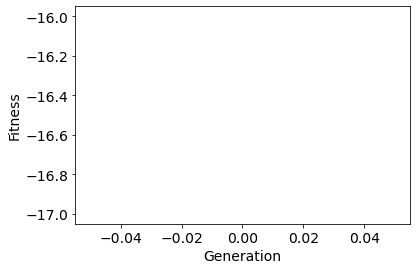

In [20]:
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14) 
plt.rc('legend', fontsize=14)

fig, ax1 = plt.subplots()
line1 = ax1.plot(gen, avgs)
ax1.set_xlabel("Generation")
ax1.set_ylabel("Fitness")

line2 = ax1.plot(gen, _min)
line3 = ax1.plot(gen, _max)

# Save the best individual and watch them play

In [21]:
bestInd = tools.selBest(pop, 1)[0]

In [22]:
myNet.setWeightsLinear(bestInd)

In [24]:
fitness = playGame( myNet, headless=False, maxTimesteps=5000)

TclError: invalid command name ".!canvas"

In [ ]:
#random.seed(datetime.now()) # Set a random seed from the clock
#playGame(AIbrain=myNet, headless=False, maxTimesteps=2000)